In [1]:
import pandas as pd
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import numpy as np
from keras.models import load_model
import time 
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy, SparseCategoricalCrossentropy
from sklearn.preprocessing import MinMaxScaler
import tensorflow_model_optimization as tfmot

NUM_OF_CLASSES = 3

def prepare_train_test_dataset():
    train_data = pd.read_csv("train_data.csv")
    train_labels = pd.read_csv("train_labels.csv")
    test_data = pd.read_csv("test_data.csv")
    test_labels = pd.read_csv("test_labels.csv")
    whole_data = pd.concat([train_data, test_data])
    min_max_scaler = MinMaxScaler().fit(whole_data)
    train_data = min_max_scaler.transform(train_data)
    test_data = min_max_scaler.transform(test_data)
    train_labels = train_labels.status.astype('category').cat.codes.to_numpy()
    # train_labels = to_categorical(train_labels,NUM_OF_CLASSES)
    test_labels = test_labels.status.astype('category').cat.codes.to_numpy()
    # test_labels = to_categorical(test_labels,NUM_OF_CLASSES)
    return (train_data, train_labels),(test_data, test_labels)

def plot_history(history, epochs_size):
    loss_list = []
    accuracy_list = []
    history_keys = history.history.keys()
    for key in history_keys:
        if "loss" in key:
            loss_list.append(key)
        
        elif "acc" in key:
            accuracy_list.append(key)
        
        elif "accuracy" in key:
            accuracy_list.append(key)

    # print(loss_list)
    # print(accuracy_list)
    
    colors = list(mcolors.BASE_COLORS.keys())
    epochs = range(1, (epochs_size+1))
    ig, ax = plt.subplots(2, figsize=(20, 8))

    for key,color in zip(loss_list, colors):
        ax[0].plot(epochs ,history.history[key], str(color), label=str(key))

    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("%")
    ax[0].set_title("Loss of Model:")
    ax[0].legend()

    for key,color in zip(accuracy_list, colors):
        ax[1].plot(epochs, history.history[key], str(color), label=str(key))
        
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("%")
    ax[1].set_title("Accuracy of Model:")
    ax[1].legend()

    # set the spacing between subplots
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.8)

    plt.show()

In [2]:
(train_data, train_labels),(test_data, test_labels) = prepare_train_test_dataset()

In [3]:
import os 
import zipfile
import tempfile
from keras.models import load_model, save_model
import tensorflow_model_optimization as tfmot
import tensorflow as tf

def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)

def create_dir(path):
  if not os.path.exists(path):
    os.mkdir(path)

def weight_pruning(baseline_model_path, train_data, train_labels, test_data, test_labels, batch_size, epochs, store_path):
    
  # create store path for models
  create_dir(store_path)

  # load baseline model from model path
  new_model = load_model(baseline_model_path)

  # evalute current baseline model accuracy
  _, baseline_model_accuracy = new_model.evaluate(
  test_data, test_labels, verbose=0)
  print('Original model test accuracy:', baseline_model_accuracy)

  # store it again: there are some problems with model overwriting, so store it again
  keras_file = os.path.join(store_path, "baseline_model.h5")
  tf.keras.models.save_model(new_model, keras_file, include_optimizer=False)
  print('Saved baseline model to:', keras_file)

  # Compute end step to finish pruning after 2 epochs.
  validation_split = 0.1 # 10% of training set will be used for validation set. 

  num_training_samples = train_data.shape[0] * (1 - validation_split)
  end_step = np.ceil(num_training_samples/batch_size).astype(np.int32) * epochs

  # Define model for pruning.
  pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.5,
                                                                final_sparsity=0.8,
                                                                begin_step=0,
                                                                end_step=end_step)
  }

  model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(new_model, **pruning_params)

  # `prune_low_magnitude` requires a recompile.
  model_for_pruning.compile(optimizer='adam',
                loss=SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  # model_for_pruning.summary()

  logdir = tempfile.mkdtemp()

  callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
  ]

  pruned_model_history = model_for_pruning.fit(train_data, train_labels, batch_size = 128, epochs=epochs, validation_split=validation_split,
                    callbacks=callbacks)
  
  plot_history(pruned_model_history, epochs)

  _, model_for_pruning_accuracy = model_for_pruning.evaluate(test_data, test_labels, verbose=0)

  print('Baseline model  test accuracy:', baseline_model_accuracy) 
  print('Pruned model test accuracy:', model_for_pruning_accuracy)

  model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

  pruned_keras_file = os.path.join(store_path,"pruned_model.h5")
  save_model(model_for_export, pruned_keras_file, include_optimizer=False)
  print('Saved pruned model to:', pruned_keras_file)

  converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
  pruned_tflite_model = converter.convert()

  pruned_tflite_file = os.path.join(store_path, "pruned_tflite_model.tflite")

  with open(pruned_tflite_file, 'wb') as f:
    f.write(pruned_tflite_model)

  print('Saved pruned TFLite model to:', pruned_tflite_file)

  print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
  print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(pruned_keras_file)))
  print("Size of gzipped pruned TFlite model: %.2f bytes" % (get_gzipped_model_size(pruned_tflite_file)))


Original model test accuracy: 0.9947068095207214
Saved baseline model to: Pruning\baseline_model.h5
Epoch 1/8
  1/542 [..............................] - ETA: 21:08 - loss: 0.0036 - accuracy: 1.0000WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0034s vs `on_train_batch_end` time: 0.0099s). Check your callbacks.


542/542 [==============================] - 5s 4ms/step - loss: 0.0711 - accuracy: 0.9785 - val_loss: 0.0244 - val_accuracy: 0.9918
Epoch 2/8
542/542 [==============================] - 2s 4ms/step - loss: 0.0234 - accuracy: 0.9914 - val_loss: 0.0153 - val_accuracy: 0.9939
Epoch 3/8
542/542 [==============================] - 2s 4ms/step - loss: 0.0662 - accuracy: 0.9772 - val_loss: 0.1129 - val_accuracy: 0.9556
Epoch 4/8
542/542 [==============================] - 2s 4ms/step - loss: 0.1540 - accuracy: 0.9470 - val_loss: 0.0630 - val_accuracy: 0.9782
Epoch 5/8
542/542 [==============================] - 2s 4ms/step - loss: 0.1462 - accuracy: 0.9582 - val_loss: 0.0801 - val_accuracy: 0.9717
Epoch 6/8
542/542 [==============================] - 2s 4ms/step - loss: 0.0625 - accuracy: 0.9763 - val_loss: 0.0441 - val_accuracy: 0.9837
Epoch 7/8
542/542 [==============================] - 2s 4ms/step - loss: 0.0454 - accuracy: 0.9849 - val_loss: 0.0224 - val_accuracy: 0.9931
Epoch 8/8
542/542 [====

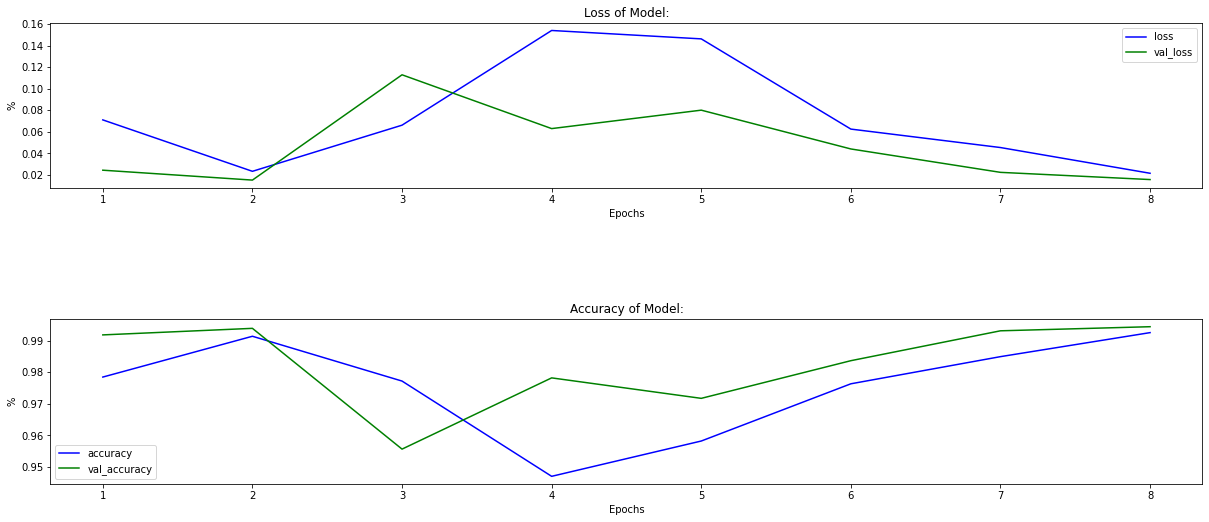

Baseline model  test accuracy: 0.9947068095207214
Pruned model test accuracy: 0.9930980801582336


Saved pruned model to: Pruning\pruned_model.h5


INFO:tensorflow:Assets written to: C:\Users\sandr\AppData\Local\Temp\tmpfl3q1jkv\assets


INFO:tensorflow:Assets written to: C:\Users\sandr\AppData\Local\Temp\tmpfl3q1jkv\assets


Saved pruned TFLite model to: Pruning\pruned_tflite_model.tflite
Size of gzipped baseline Keras model: 289656.00 bytes
Size of gzipped pruned Keras model: 95582.00 bytes
Size of gzipped pruned TFlite model: 94165.00 bytes


In [6]:
weight_pruning("fnn_model.h5", train_data, train_labels, test_data, test_labels, batch_size=128, epochs=8, store_path="Pruning")